**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [320]:
# Write your code here
import numpy as np
import scipy
from scipy.stats import norm # Nødvendig
from types import SimpleNamespace
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [13]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.eps = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [116]:
# We first define the optimal firm behaviour and implied profits as described
def firm_optimal_labor(p, w = 1) : 
    ell_j = ( ( p * par.A * par.gamma ) / w ) ** ( 1 / ( 1-par.gamma ) )
    return ell_j

def firm_optimal_output(p, w = 1) :
    y_j = par.A * ( firm_optimal_labor(p, w) ) ** par.gamma
    return y_j

def implied_profits(p, w = 1) :
    profits_j = ( ( 1 - par.gamma ) / par.gamma ) * w * firm_optimal_labor(p) 
    return profits_j


# We then define optimal consumer behaviour for a given ell 
def optimal_good_1(p1, p2, ell, w = 1) :
    cons_1 = par.alpha * ( w * ell + par.T + implied_profits(p1) + implied_profits(p2) ) / p1 
    return cons_1

def optimal_good_2(p1, p2, ell, w = 1) :
    cons_2 = ( 1 - par.alpha ) * ( w * ell + par.T + implied_profits(p1) + implied_profits(p2) ) / (p2 + par.tau)
    return cons_2


# Next we turn to the maximization problem and define the objective function that is to be minimized
def ufunc_ell(ell,p1,p2,w=1) :
    u_ell = np.log( ( optimal_good_1(p1,p2,ell,w) ** par.alpha ) * ( optimal_good_2(p1,p2,ell,w) ** ( 1 - par.alpha ) ) ) - par.nu * ( ell ** ( 1 + par.eps) ) / ( 1 + par.eps )
    return u_ell


# We have a single parameter to optimize by therefore we use scipy's minimize_scalar function to find the optimal consumption
def optimal_consumption(p1,p2) :

    def objective_ell(ell,p1,p2) :
        return -ufunc_ell(ell,p1,p2)
    
    sol = scipy.optimize.minimize_scalar(
                objective_ell,
                method = 'bounded',
                bounds = (0,2),
                args=(p1, p2) )
    
    ell_star = sol.x
    c1_star = optimal_good_1(p1,p2,sol.x)
    c2_star = optimal_good_2(p1,p2,sol.x)

    return ell_star, c1_star, c2_star


def check_market_clearing(p1,p2) :
    # Make sure the wage is numeraire

    # Optimal household behaviour
    ell_star, c1_star, c2_star = optimal_consumption(p1,p2) # Choice of labor supply and optimal consumption

    # Optimal firm behaviour
    ell_1 = firm_optimal_labor(p1) ; ell_2 = firm_optimal_labor(p2) # Choice of labor
    y_1 = firm_optimal_output(p1) ; y_2 = firm_optimal_output(p2) # Choice of output

    # Market clearing
    labor_mkt_clearing = ell_star - ( ell_1 + ell_2 )
    good1_mkt_clearing = c1_star - y_1
    good2_mkt_clearing = c2_star - y_2

    return labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing


# We then check the market clearing conditions for the set linspaces of p1 and p2. 
for i in np.linspace(0.1,2.0,10) :
    for j in np.linspace(0.1,2.0,10) :
        p1 = i  ;  p2 = j

        labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = check_market_clearing(p1,p2)
    
        # Print results
        # print(f'p1 = {p1:.3f} --> p2 = {p2:.3f} --> Labor market: {labor_mkt_clearing:.3f} --> Good market 1: {good1_mkt_clearing:.3f} --> Good market 2: {good2_mkt_clearing:.3f}')

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [145]:
# We solve for the market clearing prices using scipy.optimize.root
# We therefore define the objective function where we find when both goods markets clear
def objective_walras(p) :
    p1,p2 = p
    _, good1_mkt_clearing, good2_mkt_clearing = check_market_clearing(p1,p2)
    return good1_mkt_clearing, good2_mkt_clearing

# Initial guess: Based on the previous excercise where both good markets clearing conditions were close to 0
initial_guess = [0.944,1.578]

# We employ the optimizer
res = scipy.optimize.root(
    objective_walras, 
    initial_guess, 
    method='hybr'
)

# Print results
labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = check_market_clearing(res.x[0],res.x[1])

print(f'The market clearing prices are p1 = {res.x[0]:.3f} and p2 = {res.x[1]:.3f}')
print(f'Market clearing condition for good market 1: {good1_mkt_clearing:.3f}')
print(f'Market clearing condition for good market 2: {good2_mkt_clearing:.3f}')
print(f'Market clearing condition for labor market: {labor_mkt_clearing:.3f}')

The market clearing prices are p1 = 0.976 and p2 = 1.491
Market clearing condition for good market 1: -0.000
Market clearing condition for good market 2: -0.000
Market clearing condition for labor market: -0.000


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [148]:
# Write your answer here


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [166]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

 # Først til opgave 2
par.sigma = 2

par.v = np.array([1,2,3])
 # Først til opgave 2

# Question 2
par.F = np.arange(1,par.N+1)

# Question 3
par.c = 1

[ 1  2  3  4  5  6  7  8  9 10]


**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [249]:
# We set the seed as 2000
np.random.seed(2000)

def util(v, epsilon) :
    return v + epsilon

exp_util = np.zeros(par.J)
avg_real_util = np.zeros(par.J)

for j in range(par.J) : # Måske bare ændre til par.v
    
    # Draw the 10000 epsilons randomly from the normal distribution with mean 0 and standard deviation 2
    kepsilons = np.random.normal(0, par.sigma, par.K)
    
    # We first compute the expected utility
    exp_util[j] = par.v[j] + np.mean(kepsilons)

    # We then calculate average realized utility
    avg_real_util[j] = np.mean(par.v[j] + kepsilons)

print(f'The expected utility for v1 = {exp_util[0]:.3f}, v2 = {exp_util[1]:.3f} and v3 = {exp_util[2]:.3f}')
print(f'The average realized utility for v1 = {avg_real_util[0]:.3f}, v2 = {avg_real_util[1]:.3f} and v3 = {avg_real_util[2]:.3f}')

The expected utility for v1 = 1.003, v2 = 1.989 and v3 = 3.003
The average realized utility for v1 = 1.003, v2 = 1.989 and v3 = 3.003


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

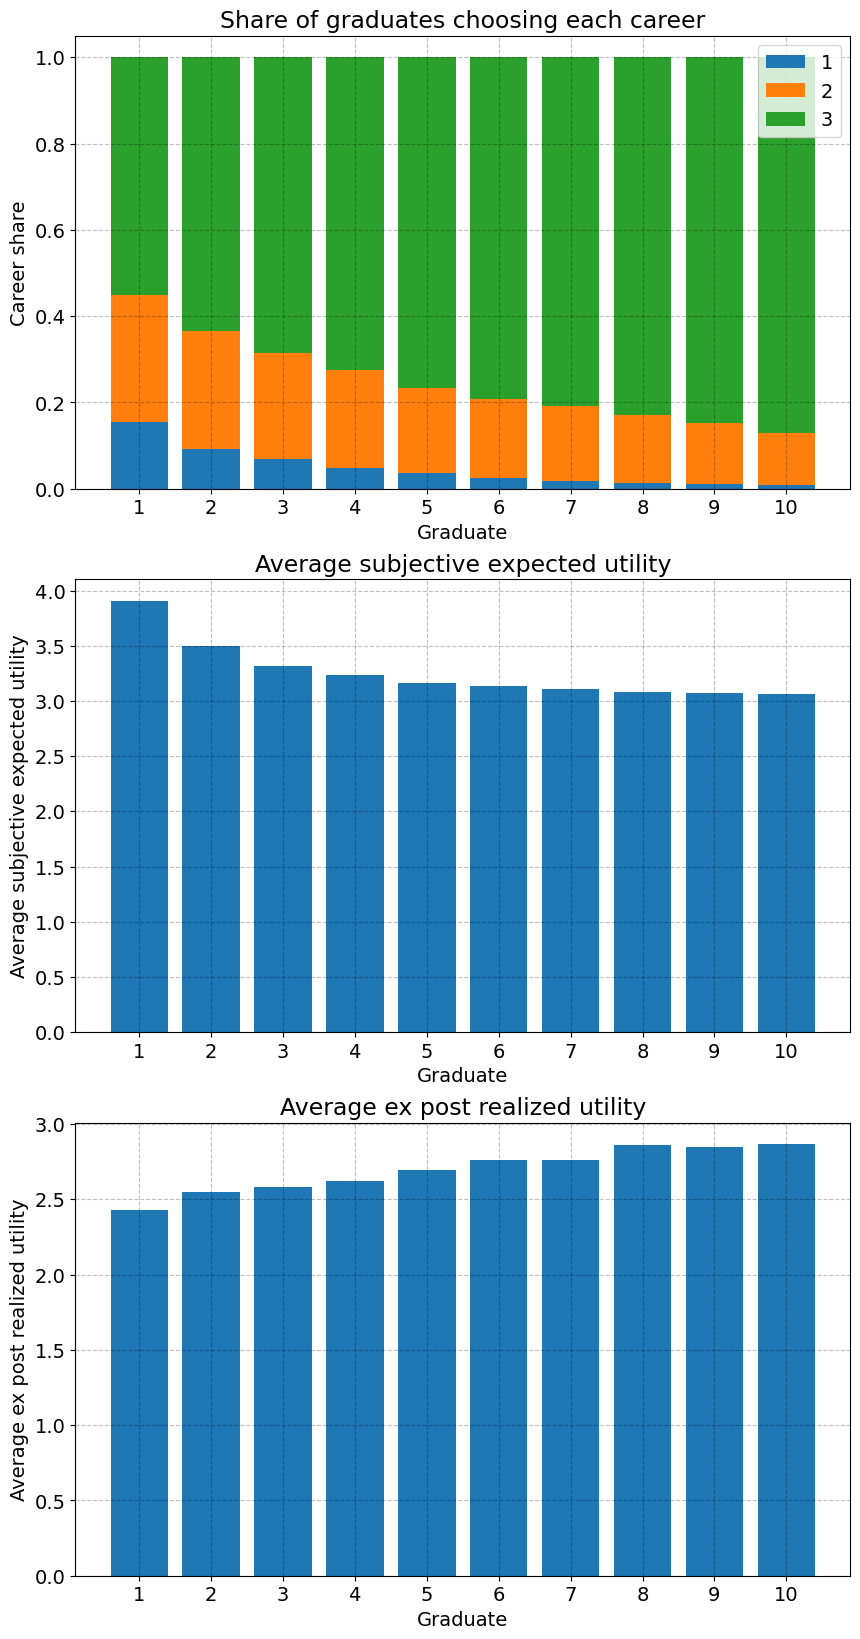

In [456]:
# We set the seed as 2000
np.random.seed(2000)

# Function that finds the chosen career tack, prior expected utility and realized utility of chosen career track for graduate i
def career_i(i) :

    prior_exp_util = np.zeros(par.J) # Each person i has a single prior expected utility for each of the J career tracks
                            # We therefore make an empty 1 x J numpy array to store each prior expected utility

    for j in range(par.J) : # We loop over each possible career path

        eps_f = np.random.normal(0, par.sigma, i) # Each person i has F friends in each career track  
                                                  # We therefore draw F = i shocks in a 1 x F numpy array 
        
        prior_exp_util[j] = np.mean(par.v[j] + eps_f) # We calculate the prior expected utility for each career track
                                                      # These are added to 1 x J numpy array

    eps_i = np.random.normal(0, par.sigma, par.J) # Each person i draws a shock for each of their J career tracks
                                                  # We therefore make a 1 x J numpy array with the shocks drawn

    # Vector of the three realized utilites
    realized_util = par.v + eps_i

    # The career track chosen
    chosen_j = np.argmax(prior_exp_util) + 1 

    # Prior expected utility
    chosen_prior = np.max(prior_exp_util)

    # Realized utility of chosen career track
    chosen_realized = par.v[chosen_j - 1] + eps_i[chosen_j - 1] 

    return chosen_j, chosen_prior, chosen_realized, prior_exp_util, realized_util 


def simulation_i(i) :

    c_track_i = np.zeros(par.K)
    c_prior_i = np.zeros(par.K)
    c_realized_i = np.zeros(par.K)

    for k in range(par.K) :
        chosen_j, chosen_prior, chosen_realized, _, _ = career_i(i)

        c_track_i[k] = chosen_j
        c_prior_i[k] = chosen_prior
        c_realized_i[k] = chosen_realized

    track_share = np.zeros(par.J)

    # Compute the share that chooses each of the J career paths
    for j in range(par.J) :
    
        indicator = np.array([ [ 1 if c_track_i[i] == j + 1 else 0 ] for i in range(par.K) ]).T[0]
        track_share[j] = np.mean(indicator)

    avg_sub_exp_util = np.mean(c_prior_i)
    avg_ex_post_real = np.mean(c_realized_i)

    return track_share, avg_sub_exp_util, avg_ex_post_real 

track_share_i = np.zeros([par.N,par.J])
avg_sub_i = np.zeros(par.N)
avg_ex_post_i = np.zeros(par.N)

for i in par.F :

    track_share, avg_sub_exp_util, avg_ex_post_real = simulation_i(i)
    
    track_share_i[i-1] = track_share
    avg_sub_i[i-1] = avg_sub_exp_util
    avg_ex_post_i[i-1] = avg_ex_post_real

    # print(f'For i = {i}: Share track 1 = {track_share[0]:.3f}, Share track 2 = {track_share[1]:.3f}, Share track 3 = {track_share[2]:.3f}, average subjective expected utility is {avg_sub_i[i-1]:.3f} and average ex post realized utility is {avg_ex_post_i[i-1]:.3f}') 

# Plotting the results
fig, ax = plt.subplots(3,1, figsize = (10,20))

ax[0].bar(par.F, track_share_i[:,0], label = '$1$') 
ax[0].bar(par.F, track_share_i[:,1], bottom = track_share_i[:,0], label = '$2$') 
ax[0].bar(par.F, track_share_i[:,2], bottom = track_share_i[:,0] + track_share_i[:,1], label = '$3$')

ax[0].set_xlabel('Graduate')
ax[0].set_ylabel('Career share')
ax[0].set_title('Share of graduates choosing each career', fontsize = 17)
ax[0].set_xticks(par.F)
ax[0].legend()


ax[1].bar(par.F, avg_sub_i)
ax[1].set_xlabel('Graduate')
ax[1].set_xticks(par.F)
ax[1].set_ylabel('Average subjective expected utility')
ax[1].set_title('Average subjective expected utility', fontsize = 17)


ax[2].bar(par.F, avg_ex_post_i)
ax[2].set_xlabel('Graduate')
ax[2].set_xticks(par.F)
ax[2].set_ylabel('Average ex post realized utility')
ax[2].set_title('Average ex post realized utility', fontsize = 17) ;




After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [457]:
# We set the seed as 2000
np.random.seed(2000)

def career_change_i(i) :

    chosen_j, _, _, prior_exp_util, realized_util  = career_i(i) 
    
    # For all but the chosen career deduct c from the realized utility
    for q in range(par.J) :
        if q + 1 == chosen_j :
            continue
        else :
            realized_util[q] = realized_util[q] - 1
            prior_exp_util[q] = prior_exp_util[q] - 1

    # Evaluate the vector of realized utility with deduction. Change career path if another career provides higher utility.
    new_career = np.argmax(realized_util) + 1

    # The updated prior and realized utility from either channging or not changing career paths.
    new_prior = np.max(prior_exp_util)
    new_realized = np.max(realized_util)

    # Indicator to show if they changed career paths.
    if new_career != chosen_j :
        change_career = 1
    else :
        change_career = 0

    return chosen_j, new_career, change_career, new_prior, new_realized



In [462]:
np.random.seed(2000)

def simulation_change_i(i) :
    
    old_career_i = np.zeros(par.K)
    new_optimal_i = np.zeros(par.K)
    new_prior_i = np.zeros(par.K)
    new_realized_i = np.zeros(par.K)

    change_track = np.zeros(par.J)
    original_track = np.zeros(par.J)

    for k in range(par.K) :
        chosen_j, new_career, change_career, new_prior, new_realized = career_change_i(i)

        old_career_i[k] = chosen_j
        new_optimal_i[k] = new_career
        new_prior_i[k] = new_prior
        new_realized_i[k] = new_realized

        # Next we compute the share that switches job conditioned on which job they originally took
        for b in range(par.J) :
            if chosen_j == b + 1 and change_career == 1 :
                change_track[b] = change_track[b] + 1

    # Number of simulations in which career paths 1, 2 or 3 where chosen
    for b in range(par.J) :
        original_track[b] = np.count_nonzero(old_career_i == b + 1, axis = 0)

    new_avg_sub_exp_util = np.mean(new_prior_i)
    new_avg_ex_post_real = np.mean(new_realized_i)
    share_condition = change_track / original_track

    return new_avg_sub_exp_util, new_avg_ex_post_real, share_condition

new_avg_sub_i = np.zeros(par.N)
new_avg_ex_post_i = np.zeros(par.N)
share_condition_i = np.zeros([par.N,par.J])


for i in par.F :

    new_avg_sub_exp_util, new_avg_ex_post_real, share_condition = simulation_change_i(i)
    
    new_avg_sub_i[i-1] = new_avg_sub_exp_util
    new_avg_ex_post_i[i-1] = new_avg_ex_post_real
    share_condition_i[i-1] = share_condition

# Shit has been calculated!!!

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [498]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [524]:
y1,y2 = y

def func_to_min(x1,x2,y1,y2) :
    composite = (x1 - y1) ** 2 + (x2 - y2) ** 2
    return composite ** (1/2) 

# Define the points
A,B,C,D = ([0,0],[0,0],[0,0],[0,0])

# Define the constraints
cons_A,cons_B,cons_C,cons_D = [(x1 > y1 and x2 > y2),(x1 > y1 and x2 < y2),(x1 < y1 and x2 < y2),(x1 < y1 and x2 > y2)]

for point,constraint in zip([A],[cons_A]) :

    value = np.inf

    for x1,x2 in X :

        print(x1 > y1 and x2 > y2)

        if constraint == True :
            temp_val = func_to_min(x1,x2,y1,y2)
        
        else :
            temp_val = np.NaN

        if temp_val < value :
            value = temp_val
            point = [x1,x2]

False
True
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
True
True
False
False
True
True
True
False
False
False
True
True
False
True
True
False
True
False
False
True
False
True
False
True
True
True
False
False
False
False
False
True
False


In [485]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

def func_to_min(x1,x2,y1,y2) :
    composite = (x1 - y1) ** 2 + (x2 - y2) ** 2
    return composite ** (1/2) 

def objective_bary(x,y) :
    return func_to_min(x[0],x[1],y[0],y[1])

def constraint_A_1(x,y) :
    return x[0] - y[0]

def constraint_A_2(x,y) :
    return x[1] - y[1]

print(X[20])
print(y)
constraint_A_1(X[20],y)





[0.24520427 0.18478708]
[0.20901926 0.37774759]


0.03618500942875147

In [ ]:
bound = (0.0,1.0)
bounds = (bound, bound)
ineq_1 = {'type': 'ineq', 'fun': constraint_A_1}
ineq_2 = {'type': 'ineq', 'fun': constraint_A_2}
initial_guess = [0.5,0.5]

result = scipy.optimize.minimize(objective_bary,
                             initial_guess,
                             method = 'SLSQP',
                             bounds = bounds,
                             args = (y,),
                             constraints = [ineq_1 , ineq_2],
                             options={'disp':True})


In [ ]:
def _objective(x1,x2,x3,x4):
    return x1*x4*(x1+x2+x3)+x3

def objective(x):
    return _objective(x[0],x[1],x[2],x[3])

def ineq_constraint(x):
    return x[0]*x[1]*x[2]*x[3]-25.0 # violated if negative

def eq_constraint(x):
    return np.sum(x**2)-40.0 # must equal zero

# a. setup
bound = (1.0,5.0)
bounds = (bound, bound, bound, bound)
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

# b. call optimizer
x0 = (40**(1/8),40**(1/8),40**(1/8),40**(1/8)) # fit the equality constraint

result = optimize.minimize(objective,x0,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [ ]:
# write your answer here

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [ ]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [ ]:
# write your answer here

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [ ]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [ ]:
# write your answer here